# Topic 34: Clustering

- 05/26/21
- onl01-dtsc-ft-022221

## Learning Objectives

- To discuss the different types of clustering algorithms
- To dive deep into K-Means clustering, how it works, and how to apply it. 
- To use K-Means clustering to identify groups in PCA-transformed data. 
- To use a ML model to explain what was capture in our PC's

## Questions

-  Can clusters be made up of other clusters?
- If a dendrogram has one leg corresponding to a point, does that mean the cluster is just one point?
- If you can’t visualize the clusters, are scoring metrics the best way to check for accuracy?


# Quick Clustering Overview 

**_Clustering_** techniques are among the most popular unsupervised machine learning algorithms. The main idea behind clustering is that you want to group objects into similar classes, in a way that:

* intra-class similarity is high
* inter-class similarity is low

> - What does _similarity_ mean? 
    - You should be thinking of it in terms of *distance*, just like we did with the K-Nearest Neighbors algorithm. 
    

<img src="https://raw.githubusercontent.com/jirvingphd/dsc-k-means-clustering-online-ds-sp-000/master/images/k_means.gif" width=60%>

- There are **hierarchical** and **nonhierarchical** clustering algorithms:
    - **Hierarchical:**
        -  **_agglomerative hierarchical_**:
            - algorithm starts with _n_ clusters (where _n_ is the number of observations, so each observation is a cluster),
            - then combines the two most similar clusters, combines the next two most similar clusters, and so on.         
        - A **_divisive_** hierarchical algorithm does the exact opposite, going from 1 to _n_ clusters.

    - **_Nonhierarchical_** algorithms choose _k_ initial clusters and reassigns observations until no improvement can be obtained. 

    - How initial clusters and reassignments are done depends on the specific type of algorithm.



**Today we will be applying K-Means clustering, a non-hierarchical clustering algorithm to identify groups of people in our PC-data NHANES data from yesterday**


# NHANES Activity Revisited:

> Preprocessing from Topic 33

In [1]:
## Lets make a preprocessing pipeline with SimpleImputer and StandardScaler

import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
import pandas as pd
import plotly.express as px
from ipywidgets import interact

from sklearn.preprocessing import StandardScaler,LabelEncoder,OneHotEncoder,MinMaxScaler
from sklearn.impute import SimpleImputer,MissingIndicator
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans

from sklearn.model_selection import train_test_split
np.random.seed(123)

# ## Changing Pandas Options to see full columns in previews and info
n=1000
pd.set_option('display.max_columns',n)
pd.set_option("display.max_info_rows", n)
pd.set_option('display.max_info_columns',n)
pd.set_option('display.float_format',lambda x: f"{x:.4f}")
plt.style.use('seaborn-notebook')

from sklearn import set_config
# set_config(display='diagram')


/var/folders/rf/vw4r41jd7vd95x1w0dth7v9h0000gp/T/ipykernel_3361/2730341599.py:26: MatplotlibDeprecationWarning: The seaborn styles shipped by Matplotlib are deprecated since 3.6, as they no longer correspond to the styles shipped by seaborn. However, they will remain available as 'seaborn-v0_8-<style>'. Alternatively, directly use the seaborn API instead.
  plt.style.use('seaborn-notebook')


In [2]:
import plotly.express as px
from ipywidgets import interact

In [8]:
import os, sys,glob

## Study Group Notebook Folderpath
folder = '../topic_33_pca/national-health-and-nutrition-examination-survey/'
os.listdir(folder)

## Use glob to get list of csvs
files = glob.glob(folder+'*.csv')
files

['../topic_33_pca/national-health-and-nutrition-examination-survey/medications.csv',
 '../topic_33_pca/national-health-and-nutrition-examination-survey/diet.csv',
 '../topic_33_pca/national-health-and-nutrition-examination-survey/examination.csv',
 '../topic_33_pca/national-health-and-nutrition-examination-survey/demographic.csv',
 '../topic_33_pca/national-health-and-nutrition-examination-survey/labs.csv',
 '../topic_33_pca/national-health-and-nutrition-examination-survey/questionnaire.csv']

In [9]:
### ADDING POST-SG: 
## the labs csv seems to have all of the troublesome duplicate columns with.x
# pd.read_csv(files[4]).columns.str.endswith('.x').sum()
test_fname = files.pop(4)
test_fname

'../topic_33_pca/national-health-and-nutrition-examination-survey/labs.csv'

#### 08/11/23 - zipping data 

In [6]:
import zipfile as zf

In [17]:
# Using pathlib for easier access to parent folder name
import pathlib as pl
path = pl.Path(test_fname)
*folders, file_only = path.parts
file_only

'labs.csv'

In [21]:
# list of nested folders
folders

['..', 'topic_33_pca', 'national-health-and-nutrition-examination-survey']

In [22]:
# The parent folder
folders[-1]

'national-health-and-nutrition-examination-survey'

In [31]:
# Get the file name and containing folder
'/'.join(path.parts[-2:])

'national-health-and-nutrition-examination-survey/labs.csv'

In [30]:
# Get the file name and containing folder
path.parts[-2] + "/" + path.parts[-1]

'national-health-and-nutrition-examination-survey/labs.csv'

In [32]:
# zip_fname = "NHANES-for-PCA.zip"
# zfile = zf.ZipFile(zip_fname,mode='w', 
#                    compression=zf.ZIP_DEFLATED, compresslevel=9)
# for file in files:
#     path = pl.Path(file)
#     zfile.write(path, arcname='/'.join(path.parts[-2:]))

In [35]:
# zfile.close()

In [37]:
zip_fname = "NHANES-for-PCA.zip"
with zf.ZipFile(zip_fname,mode='w', 
                   compression=zf.ZIP_DEFLATED, compresslevel=9) as zfile:
    for file in files:
        path = pl.Path(file)
        zfile.write(path, arcname='/'.join(path.parts[-2:]))

In [38]:
with zf.ZipFile(zip_fname) as f:
    f.extractall()
# with ZipFile(zip_fname,mode='w') as zfile:
    
#     for file in files:
#         zfile.write(file,)

### Lesson Continued

In [5]:
## Read in and concat files
df = pd.concat([pd.read_csv(file,index_col='SEQN') for file in files[1:]],
               verify_integrity=True,axis=1)
df

WTDRD1      WTDR2D  DR1DRSTZ  DR1EXMER  DRABF  DRDINT  DR1DBIH  \
SEQN                                                                        
73557  16888.3279  12930.8906    1.0000   49.0000 2.0000  2.0000   6.0000   
73558  17932.1439  12684.1489    1.0000   59.0000 2.0000  2.0000   4.0000   
73559  59641.8129  39394.2367    1.0000   49.0000 2.0000  2.0000  18.0000   
73560 142203.0699 125966.3664    1.0000   54.0000 2.0000  2.0000  21.0000   
73561  59052.3570  39004.8930    1.0000   63.0000 2.0000  2.0000  18.0000   
...           ...         ...       ...       ...    ...     ...      ...   
83551         NaN         NaN       NaN       NaN    NaN     NaN      NaN   
83593         NaN         NaN       NaN       NaN    NaN     NaN      NaN   
83635         NaN         NaN       NaN       NaN    NaN     NaN      NaN   
83652         NaN         NaN       NaN       NaN    NaN     NaN      NaN   
83657         NaN         NaN       NaN       NaN    NaN     NaN      NaN   

       DR1DAY  DR1LANG  DR1MNRSP  DR1HELPD  DBQ095Z  DBD100  DRQSPREP  DR1STY  \
SEQN                                                                            
73557  2.0000   1.0000    1.0000   13.0000   3.0000  2.0000    4.0000  2.0000   
73558  1.0000   1.0000    1.0000   13.0000   1.0000  2.0000    3.0000  1.0000   
73559  6.0000   1.0000    1.0000   13.0000   1.0000  1.0000    2.0000  2.0000   
73560  3.0000   1.0000    1.0000   12.0000   1.0000  1.0000    3.0000  2.0000   
73561  1.0000   1.0000    1.0000   13.0000   4.0000     NaN    4.0000  2.0000   
...       ...      ...       ...       ...      ...     ...       ...     ...   
83551     NaN      NaN       NaN       NaN      NaN     NaN       NaN     NaN   
83593     NaN      NaN       NaN       NaN      NaN     NaN       NaN     NaN   
83635     NaN      NaN       NaN       NaN      NaN     NaN       NaN     NaN   
83652     NaN      NaN       NaN       NaN      NaN     NaN       NaN     NaN   
83657     NaN      NaN       NaN       NaN      NaN     NaN       NaN     NaN   

       DR1SKY  DRQSDIET  DRQSDT1  DRQSDT2  DRQSDT3  DRQSDT4  DRQSDT5  DRQSDT6  \
SEQN                                                                            
73557     NaN    2.0000      NaN      NaN      NaN      NaN      NaN      NaN   
73558  1.0000    2.0000      NaN      NaN      NaN      NaN      NaN      NaN   
73559     NaN    1.0000      NaN      NaN      NaN      NaN      NaN      NaN   
73560     NaN    2.0000      NaN      NaN      NaN      NaN      NaN      NaN   
73561     NaN    1.0000      NaN      NaN      NaN      NaN      NaN      NaN   
...       ...       ...      ...      ...      ...      ...      ...      ...   
83551     NaN       NaN      NaN      NaN      NaN      NaN      NaN      NaN   
83593     NaN       NaN      NaN      NaN      NaN      NaN      NaN      NaN   
83635     NaN       NaN      NaN      NaN      NaN      NaN      NaN      NaN   
83652     NaN       NaN      NaN      NaN      NaN      NaN      NaN      NaN   
83657     NaN       NaN      NaN      NaN      NaN      NaN      NaN      NaN   

       DRQSDT7  DRQSDT8  DRQSDT9  DRQSDT10  DRQSDT11  DRQSDT12  DRQSDT91  \
SEQN                                                                       
73557      NaN      NaN      NaN       NaN       NaN       NaN       NaN   
73558      NaN      NaN      NaN       NaN       NaN       NaN       NaN   
73559   7.0000      NaN      NaN       NaN       NaN       NaN       NaN   
73560      NaN      NaN      NaN       NaN       NaN       NaN       NaN   
73561      NaN      NaN      NaN       NaN       NaN       NaN   91.0000   
...        ...      ...      ...       ...       ...       ...       ...   
83551      NaN      NaN      NaN       NaN       NaN       NaN       NaN   
83593      NaN      NaN      NaN       NaN       NaN       NaN       NaN   
83635      NaN      NaN      NaN       NaN       NaN       NaN       NaN   
83652      NaN      NaN      NaN       NaN       NaN       NaN   

In [6]:
df.columns[df.columns.str.endswith('.x')]#sum()

Index(['SMAQUEX.x'], dtype='object')

In [12]:
# Make list of column types for C.T.
nulls = df.isna().sum() / len(df)
high_null_cols = nulls[nulls>0.99].index.to_list()
num_cols = df.drop(columns=high_null_cols).select_dtypes('number').columns
cat_cols = df.drop(columns=high_null_cols).select_dtypes('object').columns



# Let's discuss - what steps am I doing? Why?
num_transformer = Pipeline(steps=[
    ('num_imputer', SimpleImputer(strategy='median')),
    ('scaler', StandardScaler())])

ohe_transformer = Pipeline(steps=[
    ('cat_imputer', SimpleImputer(strategy='constant', fill_value='MISSING')),
    ('encoder', OneHotEncoder(sparse_output=False,handle_unknown='ignore'))])

high_nulls_transformer = Pipeline(steps=[
    ('null_indicator', MissingIndicator())])


preprocessor = ColumnTransformer(
    transformers=[
        ('num', num_transformer, num_cols),
        ('cat_ohe', ohe_transformer, cat_cols), 
        ('cat_null', high_nulls_transformer, high_null_cols)])


preprocessor

ColumnTransformer(transformers=[('num',
                                 Pipeline(steps=[('num_imputer',
                                                  SimpleImputer(strategy='median')),
                                                 ('scaler', StandardScaler())]),
                                 Index(['WTDRD1', 'WTDR2D', 'DR1DRSTZ', 'DR1EXMER', 'DRABF', 'DRDINT',
       'DR1DBIH', 'DR1DAY', 'DR1LANG', 'DR1MNRSP',
       ...
       'WHD080S', 'WHD080T', 'WHD110', 'WHD120', 'WHD130', 'WHD140', 'WHQ150',
       'WHQ030M', 'WHQ500', 'WHQ520'],
      dtype='object',...
                                 Pipeline(steps=[('null_indicator',
                                                  MissingIndicator())]),
                                 ['DRQSDT4', 'DRQSDT5', 'DRQSDT6', 'DRQSDT8',
                                  'DRQSDT9', 'DRQSDT10', 'DRQSDT11', 'DRQSDT12',
                                  'DRQSDT91', 'DRD350JQ', 'DRD370HQ',
                                  'DRD370JQ', 'DRD370LQ', 'DRD370OQ',
                                  'DRD370PQ', 'DRD370QQ', 'DRD370SQ',
                                  'BMIRECUM', 'BMIHEAD', 'CSQ260D', 'ACD011B',
                                  'CSQ120A', 'CSQ120B', 'CSQ120C', 'CSQ120D',
                                  'CSQ120E', 'CSQ120F', 'CSQ120G', 'CSQ120H',
                                  'CDQ009A', ...])])

In [14]:
from sklearn import set_config
set_config(transform_output='pandas')

In [18]:
# Apply preprocessing to entire df and preview data
data_df = preprocessor.fit_transform(df)

# ## Get feature names
# encoder = preprocessor.named_transformers_['cat_ohe'].named_steps['encoder']
# feature_names = [*num_cols, *encoder.get_feature_names(cat_cols), *high_null_cols]


# ## Original Non-PC Data
# data_df = pd.DataFrame(data, columns=feature_names, index = df.index)
# data_df

## Revisiting Question Which Features are Used to Make a Principal Component

In [30]:
# Add PCA
pca = PCA(n_components=6)
df_pca = pca.fit_transform(data_df)
df_pca
# # Add the column names and check out the PC data as a dataframe
pc_feature_names = [f"PC{n}" for n in range(1,pca.n_components_+1)]
df_pca.columns= pc_feature_names
# df_pca = pd.DataFrame(pc_data, columns=pc_feature_names)
# df_pca

In [31]:
## Get Explained Variance
explained_variance = pd.Series(pca.explained_variance_ratio_,index=pc_feature_names)
explained_variance.sum()

0.12388355232709705

In [32]:
def get_pca(data_df,n_components=None,verbose=True):
    """Transforms input data with PCA using n_components
    If verbose: display explained variance ratio total"""
    ## fit_transform with PCA and make a df

    pca = PCA(n_components=n_components)
    pca_data = pca.fit_transform(data_df)
    feature_names = [f"PC{n}" for n in range(1,pca.n_components_+1)]
    df_pca = pd.DataFrame(pca_data,
                                 columns=feature_names,
                                 index=data_df.index) 

    ## Display Info re: explaained variance ratio 
    if verbose: 
        explained_variance = pd.Series(pca.explained_variance_ratio_,
                                       index=feature_names,
                                       name='Explained Variance')
        
        print(f"Total Portion of Variance Explained by PCs = {explained_variance.sum():.2f}")
        display(explained_variance)
    
    return df_pca


In [33]:
# Add PCA
pca = PCA(n_components=1000)
pc_data = pca.fit_transform(data_df)

# Add the column names and check out the PC data as a dataframe
pc_feature_names = [f"PC{n}" for n in range(1,pca.n_components_+1)]
df_pca2 = pd.DataFrame(pc_data, columns=pc_feature_names)

explained_variance = pd.Series(pca.explained_variance_ratio_,index=pc_feature_names)
explained_variance


PC1      0.0424
PC2      0.0277
PC3      0.0170
PC4      0.0144
PC5      0.0124
          ...  
PC996    0.0000
PC997    0.0000
PC998    0.0000
PC999    0.0000
PC1000   0.0000
Length: 1000, dtype: float64

<Axes: >

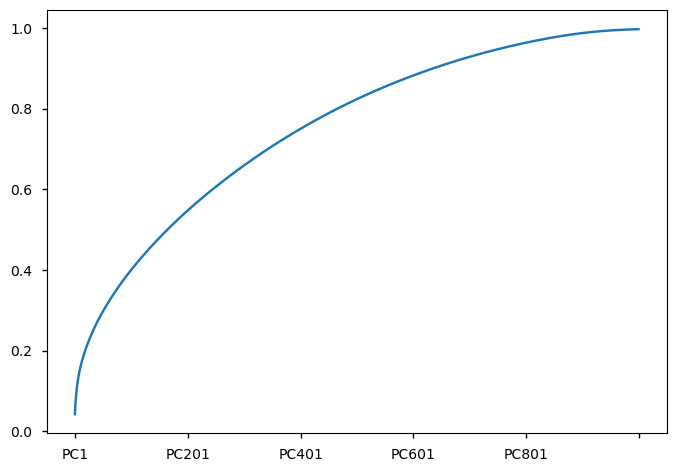

In [34]:
explained_variance.cumsum().plot()

### Visualizing our PC's

In [35]:
def plot_pca_3D(df_pca,x='PC1',y='PC2',z='PC3',color=None):
    ## Make figure and update markers
    fig  = px.scatter_3d(df_pca, x=x, y=y, z=z,color=color,
                         template='plotly_dark')
    fig.update_traces(marker={'size':2})
    
    ## Set config and show 
#     config = dict({'scrollZoom': False})
#     fig.show(config=config)

    fig.show()
    
    
plot_pca_3D(df_pca)

### Investigating Contributing Features for Each Principal Component

- 96% of me was wrong yesterday when I said that PC's are only made of 2 features. 
    - Each component actually represents some information from **every feature** in the original data. 

- Related Resources:
    - https://stackoverflow.com/questions/22984335/recovering-features-names-of-explained-variance-ratio-in-pca-with-sklearn

    - https://scikit-learn.org/stable/modules/generated/sklearn.decomposition.PCA.html

In [36]:
## Check the pca.components_
pca.components_

array([[ 4.25164907e-02,  2.92698351e-02, -2.13308042e-02, ...,
        -2.34993766e-04, -1.58784736e-04, -3.51414295e-04],
       [ 3.22305933e-02,  2.30067838e-02, -2.54312567e-02, ...,
        -4.07913336e-05, -2.25760011e-05,  9.72332621e-05],
       [-2.39124070e-02, -1.69617545e-02,  1.24858637e-02, ...,
         1.70728109e-04,  7.89108404e-05,  1.39202330e-04],
       ...,
       [-2.15311586e-02,  1.37006423e-02,  2.80862864e-02, ...,
         2.16503601e-03,  3.47675494e-03,  8.92893789e-04],
       [-2.22585032e-03, -8.78944101e-04, -9.90247123e-04, ...,
         8.13891439e-04,  9.43424773e-04, -1.04841546e-04],
       [-6.16381734e-03,  4.13784834e-03,  1.28921832e-02, ...,
         1.77674043e-04,  3.97801320e-04, -6.56437897e-04]])

In [37]:
## Whats its shape vs our original data?
print(pca.components_.shape, data_df.shape)

(1000, 2077) (10175, 2077)


In [38]:
## Making the .components into a df
components = pd.DataFrame(pca.components_, columns=data_df.columns, 
                          index=pc_feature_names)
components

num__WTDRD1  num__WTDR2D  num__DR1DRSTZ  num__DR1EXMER  num__DRABF  \
PC1          0.0425       0.0293        -0.0213        -0.0056      0.0143   
PC2          0.0322       0.0230        -0.0254        -0.0065      0.0059   
PC3         -0.0239      -0.0170         0.0125         0.0042      0.0011   
PC4         -0.0678      -0.0556         0.0050         0.0016      0.0114   
PC5         -0.0109      -0.0126         0.0041         0.0021     -0.0137   
...             ...          ...            ...            ...         ...   
PC996       -0.0119       0.0038        -0.0115        -0.0029     -0.0017   
PC997        0.0156      -0.0042         0.0027        -0.0040      0.0071   
PC998       -0.0215       0.0137         0.0281         0.0006     -0.0056   
PC999       -0.0022      -0.0009        -0.0010        -0.0051      0.0004   
PC1000      -0.0062       0.0041         0.0129        -0.0066      0.0033   

        num__DRDINT  num__DR1DBIH  num__DR1DAY  num__DR1LANG  num__DR1MNRSP  \
PC1          0.0054       -0.0047      -0.0139        0.0018        -0.0353   
PC2         -0.0046        0.0025       0.0050       -0.0082        -0.0189   
PC3         -0.0053        0.0090      -0.0048        0.0085         0.0444   
PC4         -0.0147       -0.0009       0.0121        0.0108        -0.0075   
PC5         -0.0247       -0.0019      -0.0063        0.0112         0.0142   
...             ...           ...          ...           ...            ...   
PC996        0.0013        0.0001      -0.0019        0.0009         0.0003   
PC997       -0.0042        0.0015       0.0052        0.0007         0.0012   
PC998       -0.0061       -0.0005      -0.0010        0.0056        -0.0017   
PC999        0.0064        0.0004      -0.0004       -0.0011        -0.0013   
PC1000      -0.0026       -0.0028      -0.0011       -0.0049        -0.0045   

        num__DR1HELPD  num__DBQ095Z  num__DBD100  num__DRQSPREP  num__DR1STY  \
PC1            0.0615       -0.0007       0.0356         0.0022      -0.0128   
PC2            0.0054       -0.0129       0.0173         0.0055      -0.0181   
PC3           -0.0657        0.0018      -0.0073        -0.0030       0.0054   
PC4           -0.0220        0.0253       0.0112         0.0145       0.0125   
PC5            0.0500       -0.0056       0.0087         0.0039      -0.0035   
...               ...           ...          ...            ...          ...   
PC996          0.0065       -0.0027      -0.0020         0.0049       0.0018   
PC997          0.0008       -0.0020      -0.0006         0.0012       0.0010   
PC998         -0.0051        0.0039       0.0009        -0.0012      -0.0053   
PC999         -0.0061        0.0039      -0.0006         0.0031       0.0043   
PC1000         0.0038        0.0010      -0.0026        -0.0068      -0.0018   

        num__DR1SKY  num__DRQSDIET  num__DRQSDT1  num__DRQSDT2  num__DRQSDT3  \
PC1          0.0012        -0.0140        0.0000        0.0000       -0.0000   
PC2         -0.0002        -0.0063       -0.0000       -0.0000        0.0000   
PC3          0.0026         0.0101       -0.0000       -0.0000       -0.0000   
PC4          0.0084         0.0241       -0.0000        0.0000        0.0000   
PC5          0.0019         0.0067        0.0000       -0.0000       -0.0000   
...             ...            ...           ...           ...           ...   
PC996       -0.0066        -0.0019        0.0000       -0.0000        0.0000   
PC997       -0.0004        -0.0035       -0.0000        0.0000       -0.0000   
PC998       -0.0072         0.0071        0.0000        0.0000        0.0000   
PC999        0.0032        -0.0009        0.0000       -0.0000       -0.0000   
PC1000       0.0035         0.0016        0.0000       -0.0000        0.0000   

        num__DRQSDT7  num__DR1TNUMF  num__DR1TKCAL  num__DR1TPROT  \
PC1          -0.0000         0.0279         0.0527         0.0534   
PC2          -0.0000         0.0476         0.1353         0.1

In [39]:
## Finding the features represented most by taking abs value
abs_components = components.abs().T
abs_components

PC1    PC2    PC3    PC4    PC5    PC6  \
num__WTDRD1                        0.0425 0.0322 0.0239 0.0678 0.0109 0.0575   
num__WTDR2D                        0.0293 0.0230 0.0170 0.0556 0.0126 0.0419   
num__DR1DRSTZ                      0.0213 0.0254 0.0125 0.0050 0.0041 0.0380   
num__DR1EXMER                      0.0056 0.0065 0.0042 0.0016 0.0021 0.0057   
num__DRABF                         0.0143 0.0059 0.0011 0.0114 0.0137 0.0554   
...                                   ...    ...    ...    ...    ...    ...   
cat_null__missingindicator_WHD080I 0.0008 0.0000 0.0006 0.0004 0.0009 0.0020   
cat_null__missingindicator_WHD080K 0.0003 0.0001 0.0001 0.0001 0.0005 0.0007   
cat_null__missingindicator_WHD080P 0.0002 0.0000 0.0002 0.0001 0.0006 0.0006   
cat_null__missingindicator_WHD080U 0.0002 0.0000 0.0001 0.0001 0.0001 0.0005   
cat_null__missingindicator_WHD080L 0.0004 0.0001 0.0001 0.0002 0.0001 0.0002   

                                      PC7    PC8    PC9   PC10   PC11   PC12  \
num__WTDRD1                        0.0415 0.0652 0.0050 0.0204 0.0181 0.0110   
num__WTDR2D                        0.0306 0.0514 0.0049 0.0129 0.0154 0.0113   
num__DR1DRSTZ                      0.0510 0.0059 0.0139 0.0068 0.0078 0.0463   
num__DR1EXMER                      0.0262 0.0068 0.0068 0.0026 0.0019 0.0074   
num__DRABF                         0.0382 0.0270 0.0887 0.0165 0.0042 0.0141   
...                                   ...    ...    ...    ...    ...    ...   
cat_null__missingindicator_WHD080I 0.0003 0.0003 0.0009 0.0007 0.0033 0.0002   
cat_null__missingindicator_WHD080K 0.0001 0.0003 0.0000 0.0003 0.0010 0.0004   
cat_null__missingindicator_WHD080P 0.0006 0.0005 0.0003 0.0005 0.0003 0.0003   
cat_null__missingindicator_WHD080U 0.0001 0.0003 0.0003 0.0001 0.0004 0.0002   
cat_null__missingindicator_WHD080L 0.0001 0.0001 0.0002 0.0004 0.0004 0.0005   

                                     PC13   PC14   PC15   PC16   PC17   PC18  \
num__WTDRD1                        0.0616 0.0871 0.0228 0.0672 0.0071 0.0083   
num__WTDR2D                        0.0513 0.0730 0.0151 0.0550 0.0071 0.0037   
num__DR1DRSTZ                      0.0313 0.0380 0.0010 0.0138 0.0437 0.0325   
num__DR1EXMER                      0.0120 0.0000 0.0111 0.0184 0.0016 0.0042   
num__DRABF                         0.0002 0.0120 0.0117 0.0018 0.0254 0.0269   
...                                   ...    ...    ...    ...    ...    ...   
cat_null__missingindicator_WHD080I 0.0001 0.0015 0.0005 0.0008 0.0000 0.0009   
cat_null__missingindicator_WHD080K 0.0003 0.0002 0.0001 0.0002 0.0002 0.0001   
cat_null__missingindicator_WHD080P 0.0001 0.0002 0.0002 0.0005 0.0005 0.0003   
cat_null__missingindicator_WHD080U 0.0000 0.0002 0.0003 0.0001 0.0002 0.0002   
cat_null__missingindicator_WHD080L 0.0001 0.0002 0.0001 0.0001 0.0000 0.0000   

                                     PC19   PC20   PC21   PC22   PC23   PC24  \
num__WTDRD1                        0.0093 0.0529 0.0008 0.0271 0.0098 0.1100   
num__WTDR2D                        0.0097 0.0379 0.0051 0.0154 0.0241 0.0890   
num__DR1DRSTZ                      0.0046 0.0009 0.0264 0.0146 0.0378 0.0325   
num__DR1EXMER                      0.0070 0.0053 0.0263 0.0102 0.0077 0.0112   
num__DRABF                         0.0257 0.0092 0.0472 0.0020 0.0013 0.0380   
...                                   ...    ...    ...    ...    ...    ...   
cat_null__missingindicator_WHD080I 0.0001 0.0001 0.0009 0.0015 0.0003 0.0009   
cat_null__missingindicator_WHD080K 0.0001 0.0000 0.0002 0.0001 0.0002 0.0007   
cat_null__missingindicator_WHD080P 0.0001 0.0001 0.0004 0.0007 0.0001 0.0001   
cat_null__missingindicator_WHD080U 0.0001 0.0003 0.0002 0.0001 0.0000 0.0000   
cat_null__missingindicator_WHD080L 0.0000 0.0002 0.0006 0.0004 0.0005 0.0001   

                                     PC25   PC26   PC27   PC28   PC29   PC30  \
num__WTDRD1                        0.0642 0.0246 0.0631 0.0046 0.0379 0.0626   
num__WTDR2D                       

In [40]:
## loop to get components sorted by variance
sorted_components = {}
for component_name in abs_components.columns:
    comp = abs_components[component_name].sort_values(ascending=False)
    sorted_components[component_name] = comp

In [41]:
##Check sorted vars for PC1
sorted_components['PC1'].head(20)

num__RIDAGEYR   0.1263
num__SIAPROXY   0.1232
num__BMXWT      0.1143
num__HSAQUEX    0.1103
num__BMXARMC    0.1091
num__BMXWAIST   0.1089
num__BMXARML    0.1042
num__BMXHT      0.1021
num__OHX12TC    0.0950
num__OHX05TC    0.0943
num__BMXBMI     0.0938
num__PEASCTM1   0.0927
num__OHX11TC    0.0914
num__OHX06TC    0.0904
num__OHX07TC    0.0870
num__OHX08TC    0.0866
num__OHX09TC    0.0863
num__OHX21TC    0.0863
num__OHX28TC    0.0862
num__OHX13TC    0.0862
Name: PC1, dtype: float64

In [42]:
##Check sorted vars for PC2
sorted_components['PC2'].head(20)

num__DR1TKCAL   0.1353
num__DR1TPHOS   0.1330
num__DR1TTFAT   0.1276
num__DR1TPROT   0.1263
num__DR1TSODI   0.1230
num__DR1TMFAT   0.1218
num__DR1TS160   0.1215
num__DR1TM181   0.1194
num__DR1TSFAT   0.1188
num__DR1TSELE   0.1174
num__DR1TS180   0.1157
num__DR1TMAGN   0.1151
num__DR1TPOTA   0.1143
num__DR1TZINC   0.1135
num__DR1TVB1    0.1120
num__DR1TNIAC   0.1118
num__DR1TCARB   0.1112
num__DR1TPFAT   0.1077
num__DR1TCHL    0.1077
num__DR1TP182   0.1067
Name: PC2, dtype: float64

>- Importantly, an individual component contains some information from every original feature.  PCA compresses down the information of ALL features
    - Doing what we did above is not required and doesn't change how we would use PCA or how difficult it is to explain the results re: PC features.

# K-Means Clustering Overview


#### Type of Learning
- Unsupervised

#### Assumptions
- Clusters are spherical
- Clusters are of similar size

#### Advantages
- Fast training


#### Disadvantages
- Need to determine k (# of clusters)
- Sensitive to initial points and local optima"

#### Requirements 
- Features scaled.
- Sensitive to missing data
- Sensitive to outliers.

#### Example Use:
- Segmentation

- Customer segmentation
- Outlier detection"

  
<img src="ds-clustering-main/img/from-top.gif" width=60%>
    



### How K-Means Works:

- K-Means Clustering Random Selects $k$ starting data points to use as center of clusters/"centroids"
- It then measures the distance from the centers to each datapoint.
- Reassigns data points to closest cluster and adjusts centroids.
- It optimizes the within-cluster distances and between-cluster differences

<img src="ds-clustering-main/img/min.png" width=50%>
<img src="ds-clustering-main/img/max.png" width=50%>

#### Clustering Metrics:
- [Calinski Harabasz Score](https://scikit-learn.org/stable/modules/generated/sklearn.metrics.calinski_harabasz_score.html)
    - Ratio of within-cluster dispersion to between-cluster dispersion

- [Silhouette Score](https://scikit-learn.org/stable/modules/generated/sklearn.metrics.silhouette_score.html#sklearn.metrics.silhouette_score)
    - The Silhouette Coefficient for a sample is $(b - a) / max(a, b)$. 
    - b is the distance between a sample and the nearest cluster that the sample is not a part of. Note that Silhouette Coefficient is only defined if number of labels is 2 <= n_labels <= n_samples - 1.
- Inertia:
    - Sum of Squared Errors for average distance to cluster centers. 
  

## Applying K-Means Clustering to Identify Groups of People

In [43]:
## Make interactive
feature_names = df_pca.columns
@interact(x=feature_names,y=feature_names,z=feature_names)
def interact_3D_pca(x='PC1',y='PC2',z='PC3'):
    plot_pca_3D(df_pca,x=x,y=y,z=z)

interactive(children=(Dropdown(description='x', options=('PC1', 'PC2', 'PC3', 'PC4', 'PC5', 'PC6'), value='PC1…

In [44]:
from sklearn.cluster import KMeans
from sklearn import metrics

In [45]:
## Create and fit K-Means model with n_clusters=2, random state of 321
kmeans = KMeans(n_clusters=2,random_state=321)
kmeans.fit(df_pca)

## Get predictions
kmeans.predict(df_pca)

/opt/homebrew/Caskroom/miniforge/base/envs/dojo-env/lib/python3.10/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning:

The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning



array([0, 0, 0, ..., 1, 0, 0], dtype=int32)

In [47]:
## Make into a series
clusters = pd.Series(kmeans.predict(df_pca),
                     index=df_pca.index)
clusters.value_counts(1)

0   0.6014
1   0.3986
dtype: float64

In [48]:
## Print Calinski Harabasz score
score = metrics.calinski_harabasz_score(df_pca,clusters)
print(f"Calinski-Harabasz Score = {score:.2f}")

sil_score = metrics.silhouette_score(df_pca,clusters)
print(f"Silhouette Score = {sil_score:.2f}")

## Print Model Intertia
print(f"KMeans' Inertia = {kmeans.inertia_:.2f}")

Calinski-Harabasz Score = 3459.30
Silhouette Score = 0.25
KMeans' Inertia = 966533.22


In [49]:
## Make a new plot_df from df_pca and save the clusters as a column
plot_df = df_pca.copy()
plot_df['cluster'] = clusters

## Convert cluster col to str for plotlty
plot_df['cluster'] = plot_df['cluster'].astype(str)
display(plot_df['cluster'].value_counts(1))

plot_df.head()

0   0.6014
1   0.3986
Name: cluster, dtype: float64

PC1     PC2     PC3     PC4     PC5     PC6 cluster
SEQN                                                         
73557  8.4138 -8.6900  0.3109  1.5641 -1.9146 -8.7943       0
73558 12.1579 15.2672 12.1606  1.2641  3.4557 -2.3271       0
73559  5.3599 -0.8020 -1.5336 -4.5157 -1.1415 -1.0568       0
73560 -7.4384 -0.3599  1.8861  0.6836 -3.6543 -0.5499       1
73561  7.8018 -9.0776  4.1586 -3.1022 -7.1885  1.0561       0

In [50]:
 plot_pca_3D(plot_df,'PC1','PC2','PC3',color='cluster')

In [51]:
def get_kmeans(df_pca,n_clusters=2,seed=321,verbose=False,return_df=True):
    kmeans = KMeans(n_clusters=n_clusters,random_state=seed)
    kmeans.fit(df_pca)
    
    ## Get Predictions (clusters) for train and tes
    clusters = pd.Series(kmeans.predict(df_pca),index=df_pca.index)
    
    ## Copy df as plto_df and add clsuter column
    plot_df = df_pca.copy()
    plot_df['cluster'] = clusters

    ## Convert cluster col to str for plotlty
    plot_df['cluster'] = plot_df['cluster'].astype(str)
    
    if verbose: 
        display(plot_df['cluster'].value_counts(1))
        ## Print Calinski Harabasz score
        score = metrics.calinski_harabasz_score(df_pca,clusters)
        print(f"Calinski-Harabasz Score = {score:.2f}")

        sil_score = metrics.silhouette_score(df_pca,clusters)
        print(f"Silhouette Score = {sil_score:.2f}")

        ## Print Model Intertia
        print(f"KMeans' Inertia = {kmeans.inertia_:.2f}")


    if return_df:
        return plot_df
    else:
        return clusters

In [52]:
## Test function for n_clusters = 3
plot_df = get_kmeans(df_pca,3,seed=42,verbose=True)

/opt/homebrew/Caskroom/miniforge/base/envs/dojo-env/lib/python3.10/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning:

The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning



1   0.5172
2   0.3053
0   0.1775
Name: cluster, dtype: float64

Calinski-Harabasz Score = 3374.40
Silhouette Score = 0.27
KMeans' Inertia = 778613.18


In [ ]:
# ## Use our functions to make an interactive 
# feature_names = plot_df.drop(columns='cluster').columns
# @interact(x=feature_names,y=feature_names,z=feature_names)
# def plot_pca_with_clusters(x='PC1',y='PC2',z='PC3'):
#     plot_pca_3D(plot_df,x,y,z,color='cluster')

## Visualize Different Clusters for Different Values for K

> Create a new big interactive function below:
- Combine:
    - K-Means modeling (with any k value)
    - plot_3d_pca  with a slider for k
    

In [58]:
feature_names = plot_df.drop(columns=['cluster']).columns

@interact
def test_different_ks(k=2):##,seed=321):
    x='PC1'
    y='PC2'
    z='PC3'
    plot_df = get_kmeans(df_pca,n_clusters=k,verbose=True)#a[['PC1','PC2','PC3']]
    plot_pca_3D(plot_df,x,y,z,color='cluster')

interactive(children=(IntSlider(value=2, description='k', max=6, min=-2), Output()), _dom_classes=('widget-int…

In [53]:
feature_names = plot_df.drop(columns=['cluster']).columns

@interact(x=feature_names,y=feature_names,z=feature_names, k=(0,20),
         )
def test_different_ks(x='PC1',y='PC2',z='PC3',k=2):##,seed=321):
    plot_df = get_kmeans(df_pca,n_clusters=k,verbose=True)#a[['PC1','PC2','PC3']]
    plot_pca_3D(plot_df,x,y,z,color='cluster')
  

interactive(children=(Dropdown(description='x', options=('PC1', 'PC2', 'PC3', 'PC4', 'PC5', 'PC6'), value='PC1…

>### Q: how many clusters do we think is the correct number?

# Finding the Best Value for K

## Elbow Plots

<img src="https://raw.githubusercontent.com/jirvingphd/dsc-k-means-clustering-online-ds-pt-100719/master/images/new_dim_returns.png" width=60%>

In [33]:
# model = KMeans(n_clusters=10)
# model.fit_predict()

In [34]:
df_pca

PC1     PC2     PC3     PC4     PC5     PC6
0      8.4138 -8.6901  0.3112  1.5658 -1.9088 -8.7882
1     12.1579 15.2672 12.1604  1.2660  3.4464 -2.2880
2      5.3599 -0.8020 -1.5337 -4.5158 -1.1418 -1.0611
3     -7.4384 -0.3599  1.8863  0.6835 -3.6550 -0.5544
4      7.8018 -9.0776  4.1590 -3.1022 -7.1968  1.0644
...       ...     ...     ...     ...     ...     ...
10170  4.7529 15.4211  6.8102  1.5805 -1.7726 -4.0174
10171 -8.6224 -3.0573  3.7969 -3.7500  2.4956 -1.5490
10172  2.5097  4.3028  0.7201 -2.8236 -1.5600 -0.6456
10173 -8.6671 -1.8251  4.2878 -2.3432 -2.6836  3.4323
10174 -6.4243  4.6357  4.1860  0.3929 -5.8549  0.9328

[10175 rows x 6 columns]

In [36]:
## Find best K (try 2-29), save intertia and cal har score
ks = list(range(3,30,2))
## Make empty lists for scores (cal_haz,sil,intertia)
cal_haz_scores = []
sil_scores = []
intertias = []
for k in ks:
    ## Fit model and get clusters
    model = KMeans(n_clusters=k, random_state=321)
    clusters = model.fit_predict(df_pca,)
   
    ## Get metrics
    cal_haz_scores.append(metrics.calinski_harabasz_score(df_pca,clusters))
    sil_scores.append(metrics.silhouette_score(df_pca,clusters))
    intertias.append(model.inertia_)   


In [37]:
## Turn results into dataframe with ks as the index
res_df = pd.DataFrame({'K':ks,
                      'Calinski Harabasz Score':cal_haz_scores,
                      'Intertia':intertias,
                      'Silhouette Score':sil_scores,
                      }).set_index('K')
res_df

Calinski Harabasz Score    Intertia  Silhouette Score
K                                                        
3                 3374.3613 778616.5950            0.2698
5                 3201.3401 573317.3668            0.2701
7                 2843.2916 483682.2228            0.2464
9                 2657.2434 419012.1788            0.2514
11                2532.2578 370968.9923            0.2465
13                2358.7433 342159.2010            0.2461
15                2203.2130 320917.6839            0.2410
17                2067.5382 304281.0660            0.2328
19                1952.8163 290333.8615            0.2274
21                1841.9463 279861.5719            0.2128
23                1775.2778 267209.7982            0.2161
25                1699.1637 258125.5983            0.2081
27                1637.8693 249253.1621            0.1921
29                1574.4326 242321.7082            0.1921

array([<matplotlib.axes._subplots.AxesSubplot object at 0x7f897861cb10>,
      dtype=object)

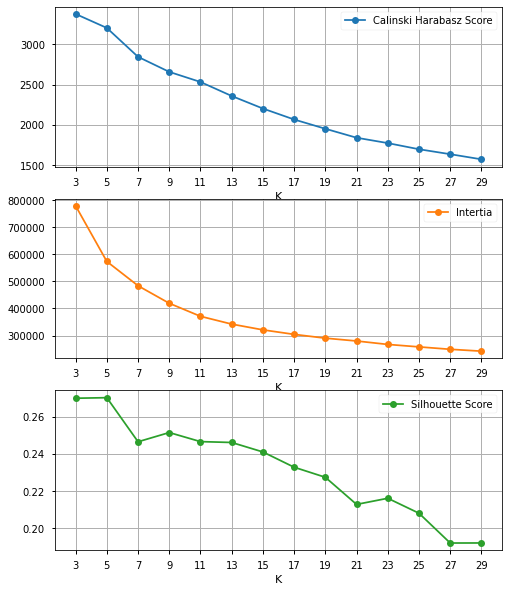

In [38]:
## Use DataFrame to PLot Metrics
# We want: subplots,lines+markers, a grid, xticks for each k
res_df.plot(subplots=True,marker='o',sharex=False,grid=True,figsize=(8,10),xticks=res_df.index)

>### Q: What value for K do we think is best?

In [39]:
## Best K
best_k = 7

In [40]:
## Use get_kmeans with best_k
cluster_df = get_kmeans(df_pca,best_k,verbose=True)
cluster_df.head()

1   0.1964
2   0.1786
0   0.1533
4   0.1422
5   0.1239
3   0.1116
6   0.0940
Name: cluster, dtype: float64

Calinski-Harabasz Score = 2843.29
Silhouette Score = 0.25
KMeans' Inertia = 483682.22


PC1     PC2     PC3     PC4     PC5     PC6 cluster
0  8.4138 -8.6901  0.3112  1.5658 -1.9088 -8.7882       3
1 12.1579 15.2672 12.1604  1.2660  3.4464 -2.2880       6
2  5.3599 -0.8020 -1.5337 -4.5158 -1.1418 -1.0611       2
3 -7.4384 -0.3599  1.8863  0.6835 -3.6550 -0.5544       1
4  7.8018 -9.0776  4.1590 -3.1022 -7.1968  1.0644       3

In [41]:
## Visualize Final Choice
feature_names = cluster_df.drop(columns=['cluster']).columns

@interact(x=feature_names,y=feature_names,z=feature_names)
def test_different_ks(x='PC1',y='PC2',z='PC3'):##,seed=321):
    plot_df = get_kmeans(df_pca,n_clusters=best_k)#,verbose=True)
    plot_pca_3D(plot_df,x,y,z,color='cluster')

interactive(children=(Dropdown(description='x', options=('PC1', 'PC2', 'PC3', 'PC4', 'PC5', 'PC6'), value='PC1…

# Using Supervised Learning Modeling to Predict & Explain Our Clusters 

- We will use our clusters identified above as the target in a new model using the ORIGINAL data (not-pca)
- We will examine feature importance to determine what features may explain the PCs we used to identify the clusters. 

In [34]:
## Get cluster_df from get_kmeans using best_K
y = get_kmeans(df_pca,best_k,verbose=True,return_df=False)
y

NameError: name 'best_k' is not defined

In [ ]:
## Use original dataframe (not-PCA) asX
X = data_df.copy()


X_train, X_test, y_train, y_test = train_test_split(X,y,random_state=321)
display(X_train.head(),y_train.head())

In [ ]:
def evaluate_model(model,X_test,y_test,classes=None,
                           normalize='true',cmap='Purples',label='',
                   return_report=False,
                   top_n=20, tree=False,return_important = False, ):
    """Accepts an sklearn-compatible classification model + test data 
    and displays several sklearn.metrics functions: 
    - classifciation_report
    - plot_confusion_matrix
    - plot_roc_curve
    """
     
    ## Get Predictions
    y_hat_test = model.predict(X_test)
    
    
    ## Classification Report / Scores 
    table_header = "[i] CLASSIFICATION REPORT"
    
    ## Add Label if given
    if len(label)>0:
        table_header += f" {label}"
        
    
    ## PRINT CLASSIFICATION REPORT
    dashes = '---'*20
    print(dashes,table_header,dashes,sep='\n')

    print(metrics.classification_report(y_test,y_hat_test,
                                    target_names=classes))
    
    report = metrics.classification_report(y_test,y_hat_test,
                                               target_names=classes,
                                          output_dict=True)
    print(dashes+"\n\n")
    
    

    ## MAKE FIGURE
    fig, ax = plt.subplots(figsize=(10,6))#,ncols=2)
    
    ## Plot Confusion Matrix 
    metrics.plot_confusion_matrix(model, X_test,y_test,
                                  display_labels=classes,
                                  normalize=normalize,
                                 cmap=cmap,ax=ax)
    ax.set(title='Confusion Matrix')
    
#     try:
#         ## Plot Roc Curve
#         roc_plot = metrics.plot_roc_curve(model, X_test, y_test,ax=axes[1])
#         axes[1].legend()
#         axes[1].plot([0,1],[0,1],ls=':')
#         axes[1].grid()
#         axes[1].set_title('Receiving Operator Characteristic (ROC) Curve') 
#         fig.tight_layout()
#     except:
#         fig.delaxes(axes[1])
#         pass
#     plt.show()

    
    
    ## Importance 
    if tree: 
        fig2,ax2 = plt.subplots()
        important = pd.Series(model.feature_importances_,index=X_test.columns).sort_values(ascending=False)
        important.sort_values().tail(top_n).plot(kind='barh',ax=ax2)
        important = important.sort_values(ascending=False)
        plt.show()

    if return_important & return_report:
        raise Exception('Only one of return_important or return_report may be True')
    if return_report:
        return report #fig,axes
    if return_important:
        return important

In [ ]:
from sklearn.ensemble import RandomForestClassifier

clf = RandomForestClassifier(random_state=321,class_weight='balanced')
clf.fit(X_train,y_train)

importance = evaluate_model(clf,X_test,y_test,tree=True,return_important=True)

In [ ]:
## save top 30 most important
most_important = importance.head(30)
most_important

In [ ]:
# ## Get top_feature names NOT ohe-names
top_features = []
for col in most_important.index:
    top_features.append(col.replace('.x','').replace('.y',''))
    
top_features = list(set(top_features))
top_features

## NHANES VARIABLE SEARCH

https://wwwn.cdc.gov/nchs/nhanes/Search/default.aspx

In [ ]:
# Search 2013-2014 dataset for variable meanings https://wwwn.cdc.gov/nchs/nhanes/Search/default.aspx
col_dict = {'LBDWFL':'Fluoride, water (mg/L) average 2 values' , 
            'BMXWT': 'Weight (kg)',
            'RIDAGEYR':'Age in years at screening',
             'LBXSCR': 'Creatinine (mg/dL)' ,
             'LBXSGTSI':'Gamma glutamyl transferase (U/L)' ,
             'BMXARML': 'Upper Arm Length (cm)',
             'BPXSY2': 'Systolic: Blood pres (2nd rdg) mm Hg',
             'CSXTSEQ': 'Whole Mouth Taste Test Sequence',
            'LBDSCRSI':'Creatinine (umol/L)',
            'LBXSATSI': 'Alanine aminotransferase ALT (IU/L)',
            'BMXARMC': 'Arm Circumference (cm)',
            'MGDCGSZ': 'Combined grip strength (kg)',
            'BMXSAD1':'Sagittal Abdominal Diameter 1st (cm)' ,
            'LBXSTR': 'Triglycerides, refrigerated (mg/dL)',
            'PFQ061D':'Stooping, crouching, kneeling difficulty',
            'LBDSTRSI': 'Triglycerides, refrigerated (mmol/L)',
            'MGXH2T2': 'Grip strength (kg), hand 2, test 2',
            'OHX06CTC': 'Coronal Caries: Tooth Count #6',
            'DR1TMOIS': 'Moisture (gm)',
            'BMXWAIST': 'Waist Circumference (cm)',
            'ORXH83':'HPV Type 83' ,
            'OHX04TC':'Tooth Count: #4',
           'PFQ061M':'Standing for long periods difficulty',
           'PFQ061T':'Push or pull large objects difficulty',
           'OHX12TC': 'Tooth Count: #12',
           'PFQ051':'Limited in amount of work you can do',
           'RIDEXAGM':'Age in months at exam - 0 to 19 years',
           'PEASCTM1':'Blood Pressure Time in Seconds',
           'ORXH61':'HPV Type 61',
           'OHX05TC':'Tooth Count: #5',
           'CDQ010':'Shortness of breath on stairs/inclines',
           'OHX27CTC':'Coronal Caries: Tooth Count #27',
           'OHX22CTC':'Coronal Caries: Tooth Count #22',
} 

new_keys = {'OHX11CTC': 'Coronal Caries: Tooth Count #11',
            'OHX21CTC':'Coronal Caries: Tooth Count #21' ,
            'OHX10CTC': 'Coronal Caries: Tooth Count #10',
            'OHX13CTC': 'Coronal Caries: Tooth Count #13',
            'OHX28CTC': 'Coronal Caries: Tooth Count #28',
            'OHX29CTC': 'Coronal Caries: Tooth Count #29',
            'BMXHT':'Standing Height (cm)',
            'PFQ061F': 'House chore difficulty',
            'OHX23CTC': 'Coronal Caries: Tooth Count #23',
            'SMQ856': 'Last 7-d worked at job not at home?',
            'OHX12CTC': 'Coronal Caries: Tooth Count #12',
            'OHX20CTC': 'Coronal Caries: Tooth Count #20',
            'DLQ050': 'Have serious difficulty walking ?',
            'PFQ049': 'Limitations keeping you from working',
            'PFQ061E': 'Lifting or carrying difficulty',
            'ORXH40': 'HPV Type 40',
            'WHQ150': 'Age when heaviest weight',
            'ORXH73': 'HPV Type 73',
            'ORXH35': 'HPV Type 35', 
            'PFQ063A': 'Health problems causing difficulty',
            'OHX04CTC':'Coronal Caries: Tooth Count #4',
           'MGXH2T3':'Grip strength (kg), hand 2, test 3',
           'OHX02CTC':"Coronal Caries: Tooth count #2",
            'BMXBMI':"Body Mass Index (kg/m**2)",
            'MGXH1T3':"Grip strength (kg), hand 1, test 3",
            'MGXH1T2':"Grip strength (kg), hand 1, test 2",
              'SMAQUEX' :"Smoking - Recent Tobacco Use (SMQRTU_H)",
              'LBDR67':'Human Papillomavirus (HPV)',
               'ORXH55':"Human Papillomaviru"
           }

col_dict.update(new_keys)

In [ ]:
missing_features = []
for feature in top_features:
    if feature in col_dict:
        print(f"Found {feature} in col_dict")
    else:
        missing_features.append(feature)

missing_features

In [ ]:
# top_features
new_features = {
    
}
col_dict.update(new_features)
# col_dict

- LB = Laboratory Measures
- BM = Body Measures

In [ ]:
# most_important

In [ ]:
len(top_features)

In [ ]:
## Make df of most important features and map details onto var name
df_importance = pd.DataFrame({'variable':top_features,'importance':most_important})
df_importance['details'] = df_importance['variable'].map(col_dict)

df_importance = df_importance[['variable','details','importance']].reset_index(drop=True)
df_importance.style.bar('importance')

## Visualize Group Differences by Most Important Features

In [35]:
## Concat back to One df
X_concat = pd.concat([X_train,X_test],axis=0,ignore_index=True)#.copy()
y_concat = pd.concat([y_train,y_test],axis=0,ignore_index=True)
y_concat.name = 'cluster'

plot_df = pd.concat([y_concat,X_concat],axis=1)
plot_df.rename(mapper=col_dict,axis=1,inplace=True)
plot_df

NameError: name 'X_train' is not defined

In [ ]:
cluster_d = {}

for cluster in plot_df['cluster'].unique():
    cluster_d[cluster] = plot_df.groupby('cluster').get_group(cluster)
cluster_d.keys()

In [ ]:
## Plot distribution of weight across clusters
col = 'Weight (kg)'
fig,ax = plt.subplots()

for cluster,df_ in cluster_d.items():

    sns.distplot(df_[col],hist_kws=dict(alpha=0.5),
                     ax=ax,kde=False,label=f"Cluster #{cluster}")
    ax.set(title=f"{col} by cluster")
    ax.legend()

In [ ]:
## Take top 20 to plot
top_20 = df_importance.head(20)['details']
top_20.dropna(inplace=True)
top_20

In [ ]:
def plot_clusters(col = 'Weight (kg)'):
    fig,ax=plt.subplots(figsize=(10,5))
    # colors = ['r','orange','green','blue']
    for cluster,df_ in cluster_d.items():
        sns.distplot(df_[col],hist_kws=dict(alpha=0.5),
                     ax=ax,kde=False,label=f"Cluster #{cluster}")
        ax.set(title=f"{col} by cluster")
        ax.legend(bbox_to_anchor=[1,1])

In [ ]:
plot_clusters()

In [ ]:
for feature in top_20:
    try:
        plot_clusters(col=feature)
    except:
        print(f'ERROR WITH {feature}')

### Student Capstone Project Using This Approach
https://github.com/Dantarshi/projectcapstone